In [3]:
from sklearn.datasets import load_svmlight_file
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

In [4]:
file_path = "../dataset/wine.data"

columns = [
    "Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium",
    "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins",
    "Color intensity", "Hue", "OD280/OD315", "Proline"
]

# Загружаем датасет
df = pd.read_csv(file_path, header=None, names=columns)


X = df.iloc[:, 1:] 
y = df.iloc[:, 0]   



In [5]:
# Нормализация (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


In [6]:
# Применяем PCA без ограничения на число компонент
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
# Получаем собственные векторы (главные компоненты)
eigenvectors = pca.components_

# Получаем собственные значения (доля объясненной дисперсии)
eigenvalues = pca.explained_variance_


In [7]:
eigen_df = pd.DataFrame(
    data=eigenvectors,
    columns=X.columns,
    index=[f"PC{i+1}" for i in range(len(eigenvalues))]
)
eigen_df["Eigenvalue"] = eigenvalues  # Добавляем столбец с собственными значениями

print("Таблица собственных значений и векторов:")
print(eigen_df)

Таблица собственных значений и векторов:
       Alcohol  Malic acid       Ash  Alcalinity of ash  Magnesium  \
PC1   0.144329   -0.245188 -0.002051          -0.239320   0.141992   
PC2   0.483652    0.224931  0.316069          -0.010591   0.299634   
PC3  -0.207383    0.089013  0.626224           0.612080   0.130757   
PC4  -0.017856    0.536890 -0.214176           0.060859  -0.351797   
PC5  -0.265664    0.035214 -0.143025           0.066103   0.727049   
PC6   0.213539    0.536814  0.154475          -0.100825   0.038144   
PC7  -0.056396    0.420524 -0.149171          -0.286969   0.322883   
PC8   0.396139    0.065827 -0.170260           0.427970  -0.156361   
PC9  -0.508619    0.075283  0.307694          -0.200449  -0.271403   
PC10  0.211605   -0.309080 -0.027125           0.052799   0.067870   
PC11 -0.225917    0.076486 -0.498691           0.479314   0.071289   
PC12 -0.266286    0.121696 -0.049622          -0.055743   0.062220   
PC13  0.014970    0.025964 -0.141218           0.

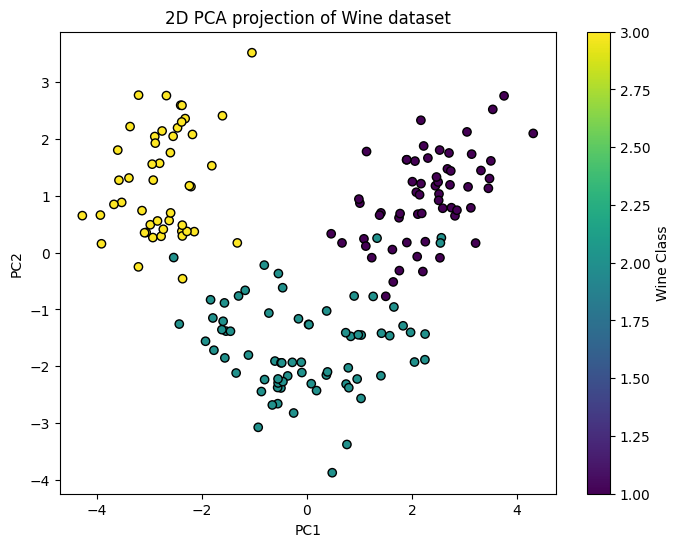

In [8]:
# Применяем PCA с 2 главными компонентами
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Визуализация данных
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA projection of Wine dataset")
plt.colorbar(label="Wine Class")
plt.show()


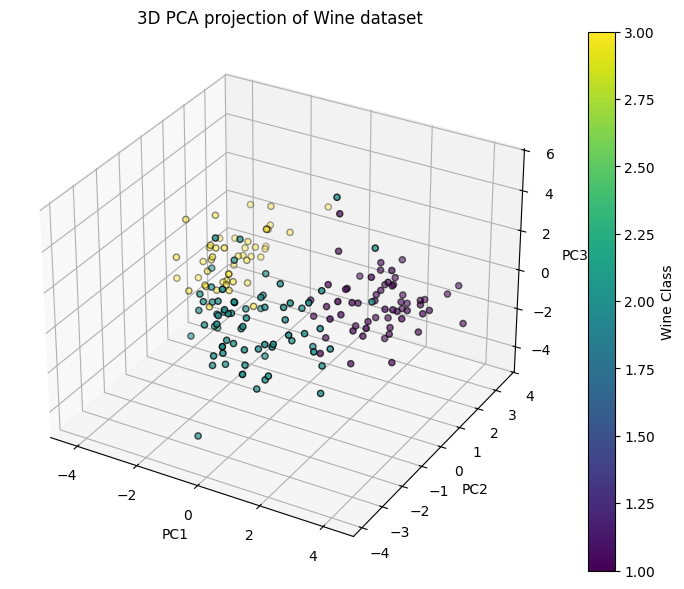

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Применяем PCA с 3 главными компонентами
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Визуализация в 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis', edgecolors='k')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA projection of Wine dataset")
plt.colorbar(sc, label="Wine Class")
plt.show()


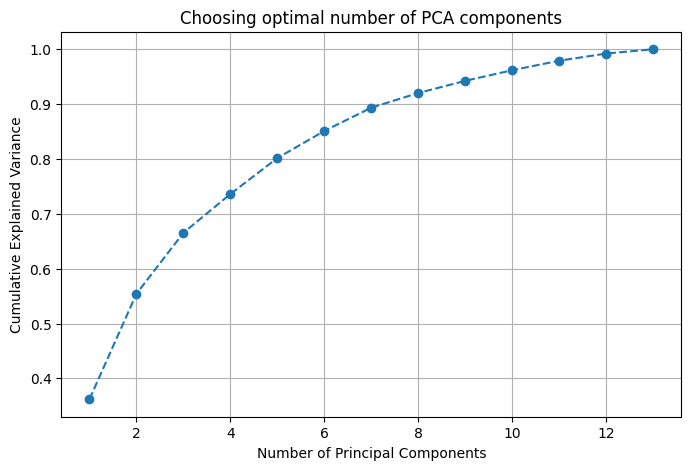

In [10]:
# Считаем накопленную долю объясненной дисперсии
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# График зависимости накопленной дисперсии от количества компонент
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Choosing optimal number of PCA components")
plt.grid()
plt.show()


In [11]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

print("Форма данных после PCA с оптимальным количеством компонент:", X_pca.shape)

Форма данных после PCA с оптимальным количеством компонент: (178, 8)


In [12]:
from sklearn.model_selection import LeaveOneOut

# Логика для Leave-One-Out
loo = LeaveOneOut()

def knn_leave_one_out(X, y, n_neighbors, weights='uniform', algorithm='auto'):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    correct, incorrect = 0, 0
    start_time = time.time()

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Изменяем здесь проверку: сравниваем y_pred и y_test, используя item() или equals() для Series
        if y_pred.item() == y_test.item():  # Для одиночных значений
            correct += 1
        else:
            incorrect += 1
    
    end_time = time.time()
    duration = end_time - start_time
    accuracy = correct / (correct + incorrect)
    
    return accuracy, correct, incorrect, duration

In [13]:


# Оценка классификатора с использованием данных после PCA
results_pca = []
for k in range(1,50,2):
     for weight_type in ['uniform', 'distance']:
        accuracy, correct, incorrect, duration = knn_leave_one_out(X_scaled, y, n_neighbors=k, weights=weight_type)
        results_pca.append({'k': k, 'weights': weight_type, 'accuracy': accuracy, 'correct': correct, 'incorrect': incorrect, 'duration': duration})

results_pca_df = pd.DataFrame(results_pca)
print(results_pca_df)

     k   weights  accuracy  correct  incorrect  duration
0    1   uniform  0.955056      170          8  0.314762
1    1  distance  0.955056      170          8  0.197284
2    3   uniform  0.955056      170          8  0.294077
3    3  distance  0.955056      170          8  0.188477
4    5   uniform  0.971910      173          5  0.312689
5    5  distance  0.971910      173          5  0.187863
6    7   uniform  0.966292      172          6  0.312565
7    7  distance  0.966292      172          6  0.225566
8    9   uniform  0.971910      173          5  0.273845
9    9  distance  0.966292      172          6  0.210495
10  11   uniform  0.977528      174          4  0.265731
11  11  distance  0.977528      174          4  0.205912
12  13   uniform  0.960674      171          7  0.317575
13  13  distance  0.966292      172          6  0.227473
14  15   uniform  0.966292      172          6  0.283842
15  15  distance  0.966292      172          6  0.206005
16  17   uniform  0.960674     

In [14]:
def leave_one_out_classifier(X, y, clf):
    loo = LeaveOneOut()
    correct, incorrect = 0, 0
    start_time = time.time()

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        if y_pred.item() == y_test.item():
            correct += 1
        else:
            incorrect += 1
    
    end_time = time.time()
    duration = end_time - start_time
    accuracy = correct / (correct + incorrect)
    
    return accuracy, correct, incorrect, duration

In [15]:
# K-Nearest Neighbors
results_knn = []
for k in range(1,50,2):  # Тестируем разные значения k
    clf_knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')  # KNN с равными весами
    accuracy, correct, incorrect, duration = leave_one_out_classifier(X_scaled, y, clf_knn)
    results_knn.append({'k': k, 'method': 'KNN', 'accuracy': accuracy, 'correct': correct, 'incorrect': incorrect, 'duration': duration})

# Radius Neighbors

radius_results = []
for radius1 in range(400,550,5): 
    radius = radius1 / 100 # Пример разных радиусов
    clf = RadiusNeighborsClassifier(radius=radius, algorithm='auto')
    accuracy, correct, incorrect, duration = leave_one_out_classifier(X_scaled, y, clf)
     # Например, использовать одинаковый k
    radius_results.append({'method': 'Radius Neighbors','radius': radius, 'accuracy': accuracy, 'correct': correct, 'incorrect': incorrect, 'duration': duration})

# Объединяем результаты для всех методов

# Nearest Centroid
results_centroid = []
clf_centroid = NearestCentroid()  # Nearest Centroid
accuracy, correct, incorrect, duration = leave_one_out_classifier(X_scaled, y, clf_centroid)
results_centroid.append({'method': 'Nearest Centroid', 'accuracy': accuracy, 'correct': correct, 'incorrect': incorrect, 'duration': duration})

# Объединяем все результаты в одну таблицу
results_all = results_knn + radius_results + results_centroid
results_df = pd.DataFrame(results_all)

# Выводим таблицу с результатами
print(results_df)



       k            method  accuracy  correct  incorrect  duration  radius
0    1.0               KNN  0.955056      170          8  0.324988     NaN
1    3.0               KNN  0.955056      170          8  0.263520     NaN
2    5.0               KNN  0.971910      173          5  0.330537     NaN
3    7.0               KNN  0.966292      172          6  0.302430     NaN
4    9.0               KNN  0.971910      173          5  0.304844     NaN
5   11.0               KNN  0.977528      174          4  0.304660     NaN
6   13.0               KNN  0.960674      171          7  0.290580     NaN
7   15.0               KNN  0.966292      172          6  0.345994     NaN
8   17.0               KNN  0.960674      171          7  0.276311     NaN
9   19.0               KNN  0.971910      173          5  0.296367     NaN
10  21.0               KNN  0.971910      173          5  0.271883     NaN
11  23.0               KNN  0.971910      173          5  0.302136     NaN
12  25.0               KN